# 量的データ用（For quantitaive data）
[Methods]  
- Clustering methods : Kmeans, GMM, FSSEM, FSS-Kmeans    
- Allocation methods : random, proportional allocation, post stratification, optimal allocation

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# シード設定
# from lightning.pytorch import seed_everything
# seed_everything(8)

# 可視化の設定
import matplotlib.pyplot as plt
from matplotlib import cm
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

--------
### 実験設定

In [2]:
TARGET = "spend"

TRAIN_SIZE = 10000
TEST_SIZE = 10000

RANDOM_STATE = 0  # 乱数シード

N_CLUSTERS = 10
K_MIN = 2
K_MAX = 10

-----------
### データの前処理（Data Preprocessing）

In [7]:
df_all = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv"
)

df_all = df_all[df_all["segment"] == "No E-Mail"]

features_list = [
    "recency",
    "history",
    "mens",
    "womens",
    "newbie",
]

variables_list = [
    TARGET,
    "recency",
    "history",
    "mens",
    "womens",
    "newbie",
]

ALL_FEATURES_INDEX = [i for i in range(len(features_list))]

print(df_all)
df_train = df_all.iloc[:TRAIN_SIZE]
df_test = df_all.iloc[TRAIN_SIZE : TRAIN_SIZE + TEST_SIZE]

print(df_train)
print(df_test)


       recency history_segment  history  mens  womens   zip_code  newbie  \
1            6  3) $200 - $350   329.08     1       1      Rural       1   
14           4  3) $200 - $350   241.42     0       1      Rural       1   
15           3    1) $0 - $100    58.13     1       0      Urban       1   
20           9    1) $0 - $100    29.99     0       1  Surburban       1   
23           2    1) $0 - $100    29.99     0       1      Urban       1   
...        ...             ...      ...   ...     ...        ...     ...   
63980        3  4) $350 - $500   487.10     0       1  Surburban       1   
63981        4  2) $100 - $200   125.53     0       1      Rural       1   
63983        2    1) $0 - $100    83.03     0       1      Urban       0   
63987        1    1) $0 - $100    79.70     1       0  Surburban       1   
63990        6    1) $0 - $100    80.02     0       1  Surburban       0   

            channel    segment  visit  conversion  spend  
1               Web  No E-Ma

In [8]:
X_train = df_train[features_list].to_numpy()
y_train = df_train[TARGET].to_numpy()

X_test = df_test[features_list].to_numpy()
y_test = df_test[TARGET].to_numpy()

In [9]:
sc = StandardScaler()
# 訓練データに基づいてfit
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

-------------
### Kmeansのクラスタ数確認

In [10]:
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
labels = kmeans.fit_predict(X_test_std)
cluster_size = np.bincount(labels)

print(cluster_size)

[1010 1139 1092 1036  736 1140 1021 1018 1189  619]


-------------
### Xmeans で確認

##### Xmeans

In [11]:
def compute_bic(X, kmeans):
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_k = k_min
    score_dict = {}
    score_dict[k_min] = best_bic
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        score_dict[k] = current_bic
        if current_bic < best_bic:
            best_bic = current_bic
            best_k = k
    return best_k, score_dict

##### クラスタリング結果

n_clusters chosen in Xmeans: 10


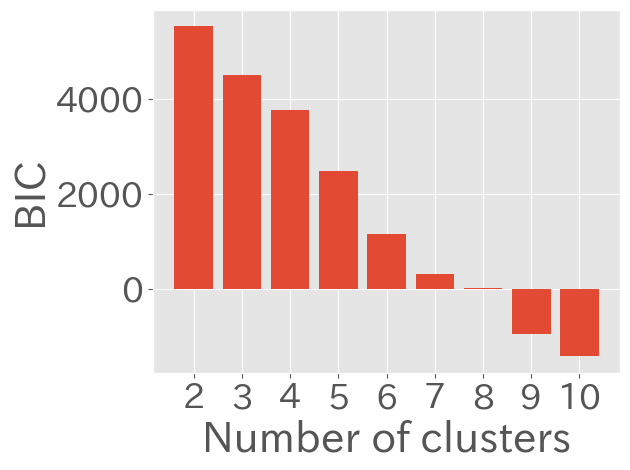

In [12]:
best_k, score_dict = xmeans(X_train_std, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen in Xmeans:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("BIC", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()

-----------------------------
### シルエット係数で確認

In [13]:
def silhouette(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    labels = kmeans.predict(X)
    best_score = silhouette_score(X, labels)
    score_dict = {}
    score_dict[k_min] = best_score
    best_k = k_min
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        labels = kmeans.predict(X)
        current_score = silhouette_score(X, labels)
        score_dict[k] = current_score
        if current_score > best_score:
            best_score = current_score
            best_k = k
    return best_k, score_dict

##### 結果

n_clusters chosen in Xmeans: 10


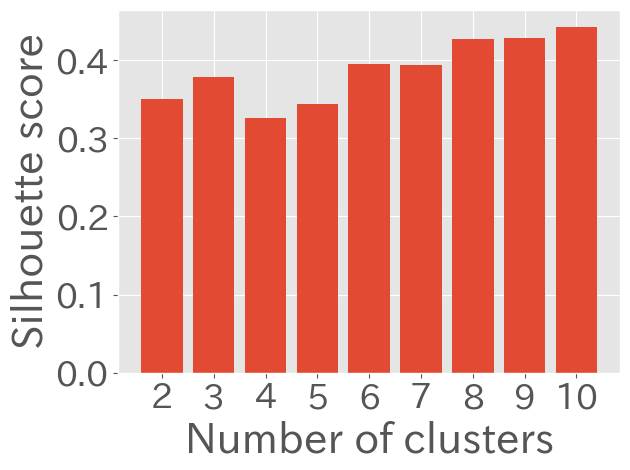

In [14]:
best_k, score_dict = silhouette(X_train_std, k_min=K_MIN, k_max=K_MAX)
print("n_clusters chosen in Xmeans:", best_k)

x = []
for k in score_dict.keys():
    x.append(str(k))
y = [score for score in score_dict.values()]
bars = plt.bar(x, y)
plt.ylabel("Silhouette score", fontsize=30)
plt.xlabel("Number of clusters", fontsize=30)
plt.tick_params(axis="both", which="major", labelsize=25)
plt.tight_layout()
plt.show()

In [15]:
print(score_dict)

{2: 0.35023149835648326, 3: 0.3788619317490991, 4: 0.32596738845398754, 5: 0.3433421144185523, 6: 0.39508780242288205, 7: 0.3939440919459549, 8: 0.42740461715403216, 9: 0.4284123429650337, 10: 0.44217792419336965}


### シルエット図

In [16]:
def plot_silhouette_diagram(n_clusters: int, X):
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(X)
    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]

    silhouette_vals = silhouette_samples(X, labels, metric="euclidean")
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(
            range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor="none",
            color=color,
        )
        yticks.append((y_ax_lower + y_ax_upper) / 2.0)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel("Cluster", fontsize=30)
    plt.xlabel("Silhouette coefficient", fontsize=30)
    plt.tick_params(axis="both", which="major", labelsize=25)
    plt.xlim(-0.6, 0.6)
    plt.tight_layout()
    plt.show()

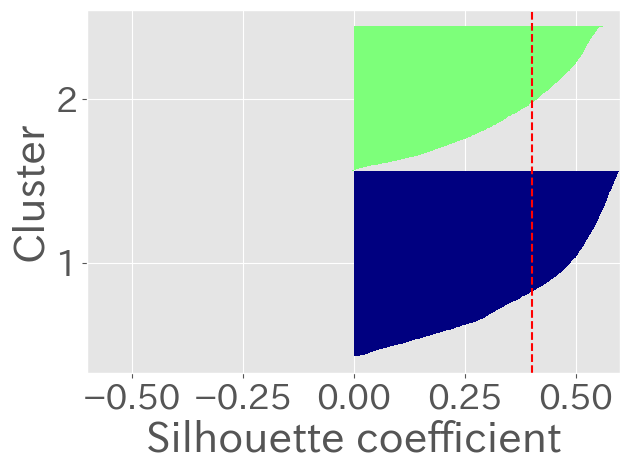

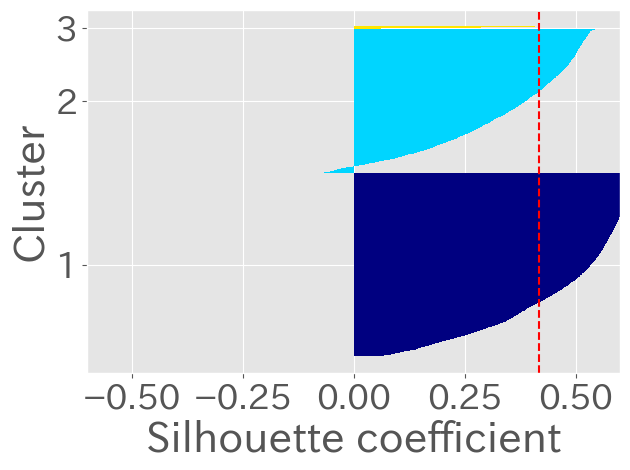

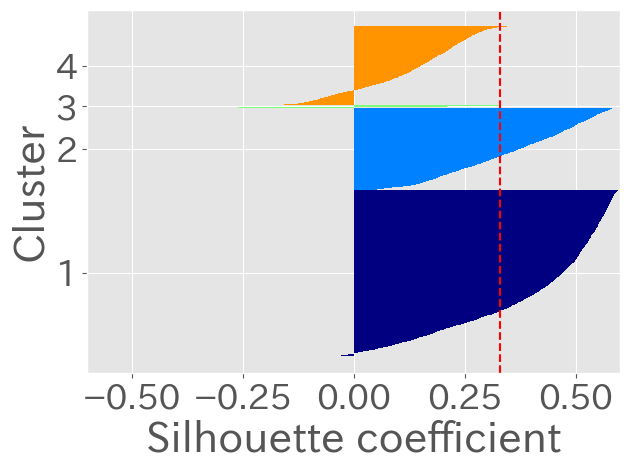

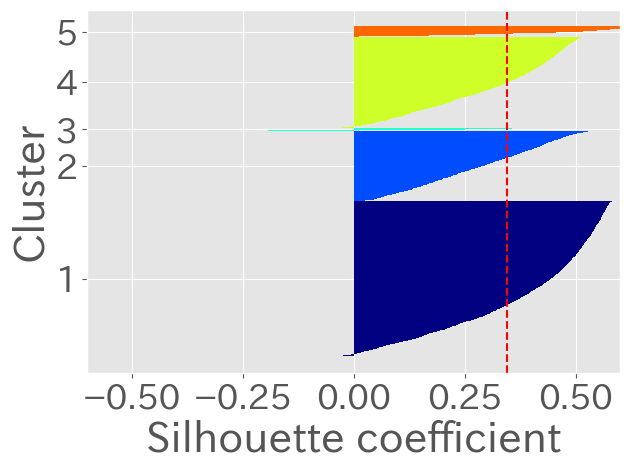

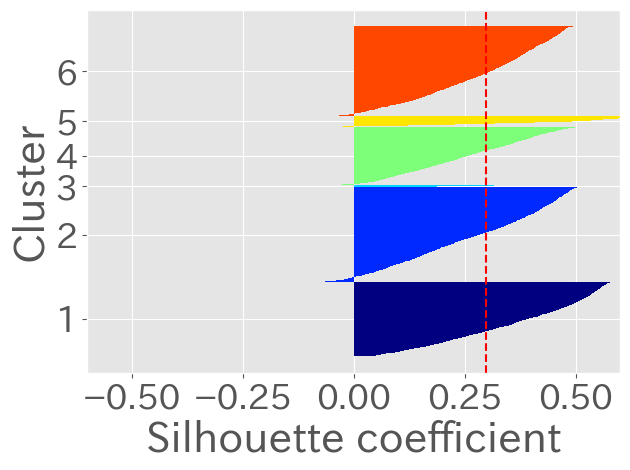

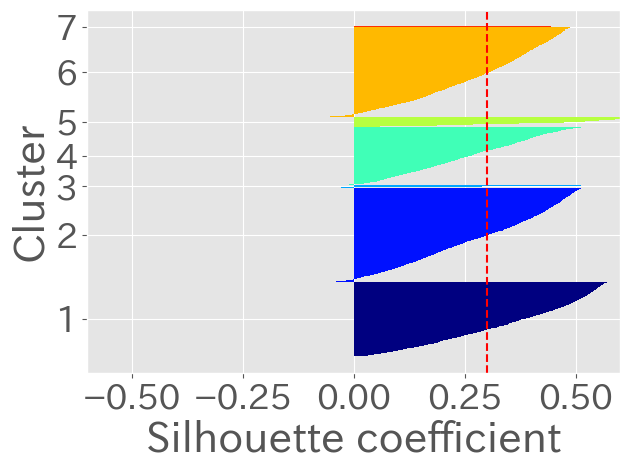

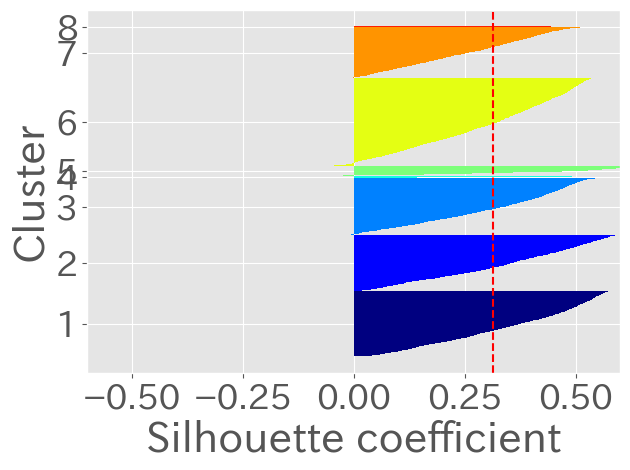

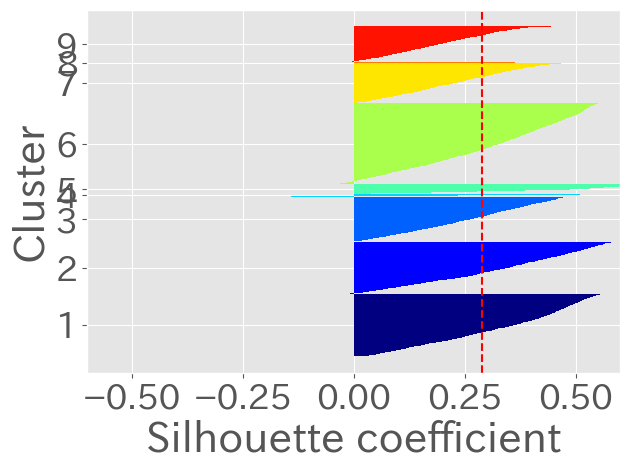

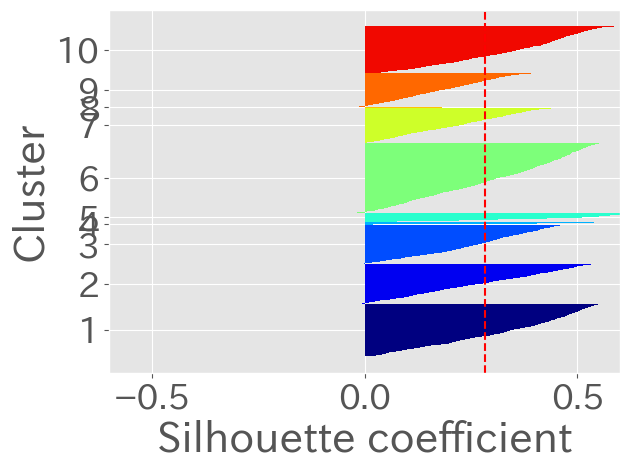

In [17]:
for n_clusters in range(K_MIN, K_MAX + 1):
    plot_silhouette_diagram(n_clusters=n_clusters, X=X_train_std)

-----
## エルボー図

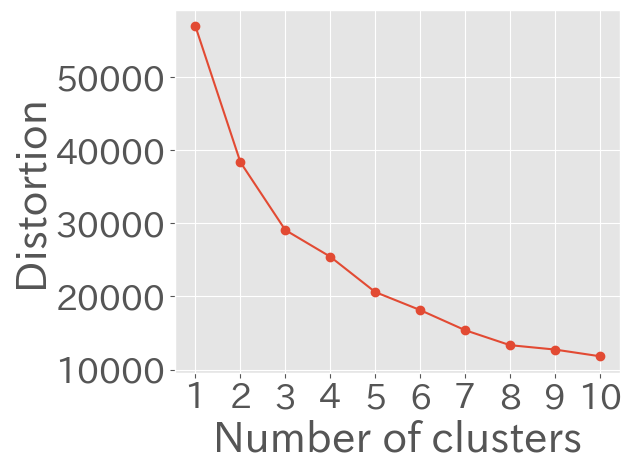

In [18]:
distortions = []
for i in range(K_MIN - 1, K_MAX + 1):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_train_std)
    distortions.append(kmeans.inertia_)

plt.plot(range(K_MIN - 1, K_MAX + 1), distortions, marker="o")
plt.xlabel("Number of clusters", fontsize=30)
plt.ylabel("Distortion", fontsize=30)
plt.xticks(range(K_MIN - 1, K_MAX + 1))
plt.tick_params(axis="both", labelsize=25)
plt.tight_layout()
plt.show()